_Last updated 04/19/2021_

In [1]:
import gurobipy as gp
from gurobipy import GRB, max_, abs_
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from graphviz import Digraph, Graph
%matplotlib inline

# Two layer NN MIP

MIP to model a simple NN with 0/1 activations, 0/1 output; one input layer, one hidden layer, and one output layer

__Parameters:__

$ x_{n,d}: \textit{binary vector inputs of size n} \times \textit{d, where n is the number of data points, d is the number of features} $ 

$ y_{n}: \textit{binary  vector labeled outputs of size n} \times \textit{1, where n is the number of data points} $

__Decision Variables:__


$ W_{(hidden)d,k}: \textit{weight for feature d in unit k in the hidden layer,}\forall\;d \in D,\;k \in K $

$ \beta_{(hidden)k}: \textit{bias for unit k,}\forall\;k \in K $

$ W_{(final)k}: \textit{weight in unit k in the final layer,}\forall\;k \in K $

$ \beta_{(final)}: \textit{bias in the final layer} $

$ \ell_{n}: \textit{loss of data point n,} \forall\;n \in N $

$ h_{n,k}: \textit{binary output of unit k,} \forall\;n \in N $

$ z_{n,k}: \textit{Auxilliary variable that represents}\; W_{(final)k}h_{n,k},\forall\;n \in N \;k \in K $ 

__Objective:__

$\displaystyle \min_{w, \beta,\ell,h,z} \; \displaystyle  \sum_{n=1}^{N} \ell_{n} $

__Constraints:__

subject to $\quad y_{n}(\displaystyle  \sum_{k=1}^{K} z_{n,k} + \beta_{(final)}) \ge 1-\ell_{n}, \; \forall \; n \in N $


$ \quad\quad\quad\quad\;\; W_{k}^{T}x_{n} + \beta_{(hidden)k} \le 0 - \epsilon + (M+\epsilon)h_{n}, \; \forall \; n \in N, \; k \in K $

$ \quad\quad\quad\quad\;\; W_{(hidden)k}^{T}x_{n} + \beta_{(hidden)k} \ge \epsilon + (m-\epsilon)(1-h_{n}), \; \forall \; k \in K, \; n \in N $

$ \quad\quad\quad\quad\;\; z_{n,k} - W_{(final)k} \le M(1-h_{n,k}), \; \forall\;n \in N \;k \in K \;d \in D $

$ \quad\quad\quad\quad\;\; z_{n,k} - W_{(final)k} \ge m(1-h_{n,k}), \; \forall\;n \in N \;k \in K \;d \in D $

$ \quad\quad\quad\quad\;\;  0 \le z_{n,k} \le h_{n,k}, \; \forall\;n \in N \;k \in K \;d \in D $


$ \quad\quad\quad\quad\;\; Lower\;Bound \le W{(hidden)d,k},\;W{(final)k}\le Upper\;Bound, \; \forall \; k\;d $

$ \quad\quad\quad\quad\;\; Lower\;Bound \le \beta_{(hidden)k}\; \beta_{(final)} \le Upper\;Bound, \; \forall \; k \in K$

$ \quad\quad\quad\quad\;\; 0 \le \ell_{n} \le 1, \; \forall \; n$

$ \quad\quad\quad\quad\;\; h_{n,k}  \in \{0,1\}, \; \forall \; n, \;k$



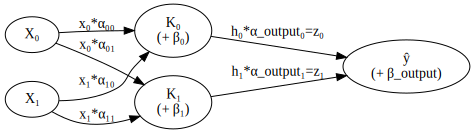

In [2]:
SUB = str.maketrans("0123456789mn", "₀₁₂₃₄₅₆₇₈₉ₘₙ")

g = Digraph()
g = Digraph(graph_attr={'rankdir':'LR'})
g.edge("X0".translate(SUB), "K0 \n (+ β0)".translate(SUB), label = "x0*α00".translate(SUB))
g.edge("X0".translate(SUB), "K1 \n (+ β1)".translate(SUB), label = "x0*α01".translate(SUB))
g.edge("X1".translate(SUB), "K0 \n (+ β0)".translate(SUB), label = "x1*α10".translate(SUB))
g.edge("X1".translate(SUB), "K1 \n (+ β1)".translate(SUB), label = "x1*α11".translate(SUB))
g.edge("K0 \n (+ β0)".translate(SUB), "ŷ \n (+ β_output)".translate(SUB), label = "h0*α_output0=z0".translate(SUB))
g.edge("K1 \n (+ β1)".translate(SUB), "ŷ \n (+ β_output)".translate(SUB),label = "h1*α_output1=z1".translate(SUB))
g

<center>Hidden layer Mechanics</center>

$$ \overrightarrow{h} = \begin{pmatrix} \alpha_{00} & \alpha_{10} \\ \alpha_{01} & \alpha_{11} \end{pmatrix} \begin{pmatrix} x_{0} \\ x_{1} \end{pmatrix} + \begin{pmatrix} \beta_{0} \\ \beta_{1} \end{pmatrix} = \begin{pmatrix} \alpha_{00}x_{0} + \alpha_{10}x_{1} + \beta_{0} \\ \alpha_{01}x_{0} + \alpha_{11}x_{1} + \beta_{1} \end{pmatrix} = \begin{pmatrix} h_{0} \\ h_{1} \end{pmatrix} $$
<br>
<center>Output layer Mechanics</center>
$$ \hat{y} = \begin{pmatrix} \alpha_{\textrm{output},0} & \alpha_{\textrm{output},1} \end{pmatrix} \begin{pmatrix} h_{0} \\ h_{1} \end{pmatrix}  + \beta_{\textrm{output}}$$

### Version 1

In [3]:
# The above MIP is parsed into the following function as python code using gurobi

def MIPOptimizer1(data, output, units, w_lb=-1.0, w_ub=1.0, b_lb=-1.0, b_ub=1.0): 
        
    # Eventually update function and MIP to work on more than one layer

    # Create a new model
    m = gp.Model("simpleNN1")

    K = units # number of units per layer
    N = output.shape[0] # number of units in the training set
    D = data[0].shape[0] # dimension of data
    epsilon = 0.01

    x = data # binary feature matrix n x d
    y = output # labeled data n x 1

    assert x.shape[0] >= y.shape[0] # assert the same number of columns for the input and output
                                    # each data point as at least one corresponding output
        
    # Create variables

    weights_hidden = {}
    weights_output = {}
    bias_hidden = {}
    bias_output = None
    loss = {}
    h = {}
    z = {}
    
    for k in range(K):
        weights_output[k] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="w_output"+str(k)) # weights for output layer
        
        bias_hidden[k] = m.addVar(lb=b_lb, ub=b_ub, vtype=GRB.CONTINUOUS, name="b_hidden"+str(k)) # bias for the hidden layer
    
        for d in range(D):
            weights_hidden[(d,k)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="w_hidden"+str((d,k))) # weights for hidden layer
    
    for n in range(N):
        
        loss[n] = m.addVar(lb = 0, ub = 1, vtype=GRB.CONTINUOUS, name="loss"+str(n)) # loss
        
        for k in range(K):
            h[(n,k)] = m.addVar(vtype=GRB.BINARY, name="h"+str((n,k+1))) # output of first layer
        
            z[(n,k)] = m.addVar(lb=0, ub=w_ub, vtype=GRB.CONTINUOUS, name= "z"+str((n,k))) # Auxilliary variable to account for the h*w

    bias_output = m.addVar(lb=b_lb, ub=b_ub, vtype=GRB.CONTINUOUS, name="b_output") # bias for the output layer

    # Set objective
    m.setObjective(sum(loss[n] for n in range(N)), GRB.MINIMIZE)

    # Add constraints

    for n in range(N):
        m.addConstr(y[n]*(sum(z[(n,k)] for k in range(K)) + bias_output) >= 
                    1.0 - loss[n], name="Final layer loss definition"+str(n)) 

    for n in range(N):
        for k in range(K):
            
            m.addConstr(sum(weights_hidden[(d,k)]*x[n,d] for d in range(D)) + bias_hidden[k] 
                        <= 0.0 - epsilon + (D*w_ub+b_ub + epsilon)*h[n,k], name="b"+str((n,k))) # M is sum of upper-bounds
            
            m.addConstr(sum(weights_hidden[(d,k)]*x[n,d] for d in range(D)) + bias_hidden[k] 
                        >= 0.0 + epsilon + (D*w_lb+b_lb - epsilon)*(1-h[n,k]), name="c"+str((n,k))) # m is sum of lower-bounds

    for n in range(N):
        for k in range(K):
            m.addConstr(z[(n,k)] <= weights_output[k] + (w_ub-w_lb)*(1.0-h[(n,k)]), name="d"+str((n,k))) # M = 2
            m.addConstr(z[(n,k)] >= weights_output[k] + (w_lb-w_ub)*(1.0-h[(n,k)]), name="e"+str((n,k))) # M = -2
            m.addConstr(z[(n,k)] <= (w_ub)*h[(n,k)], name="f"+str((n,k))) # M = 1

    # Optimize model
    m.optimize()

    output_dict = {}
    
    for v in m.getVars():
        print('%s %s %g' % (v.varName, "=", np.round(v.x, 3)))
        output_dict[v.varName] = np.round(v.x, 3)

    print('Obj: %g' % m.objVal)
    
    return(m.objVal, output_dict)


### XOR Gate with Optimizer 1

In [4]:
X = np.array([[0,0],[0,1], [1,0], [1,1]])
Y = np.array([0,1,1,0])
Y = (Y*2)-1
# We have 4 data points (n = 4) with 2 features each (d = 2) and we are going to use 2 units in 2 layers

In [5]:
loss, output = MIPOptimizer1(X, Y, units=2)

Academic license - for non-commercial use only - expires 2021-07-16
Using license file /Library/gurobi911/gurobi.lic
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 44 rows, 29 columns and 128 nonzeros
Model fingerprint: 0x9e97d201
Variable types: 21 continuous, 8 integer (8 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 3e+00]
Presolve removed 0 rows and 2 columns
Presolve time: 0.00s
Presolved: 44 rows, 27 columns, 118 nonzeros
Variable types: 19 continuous, 8 integer (8 binary)

Root relaxation: objective 1.990050e-02, 27 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.01990    0    8          -    0.01990      -     -    0

<center>Hidden layer Mechanics with our weights and biases obtained</center>

$$ \overrightarrow{h} = \begin{pmatrix} -0.02 & -0.99 \\ -0.02 & -0.99 \end{pmatrix} \begin{pmatrix} x_{1} \\ x_{2} \end{pmatrix} + \begin{pmatrix} 1 \\ 1 \end{pmatrix} = \begin{pmatrix} -0.02x_{1} - 0.99x_{2} + 1 \\  -0.02x_{1} - 0.99x_{2} + 1 \end{pmatrix}\;each\;row\;is\;converted\;to\;0\;or\;1\;when\;\le\;0\;or\;>\;0\;respectively $$

<br>

<center>Output layer Mechanics with our weights and biases obtained</center>
$$ \hat{y} = \begin{pmatrix} 1 & 1 \end{pmatrix} \begin{pmatrix} 0\;or\;1 \\  0\;or\;1\end{pmatrix} - 1 $$ 

### Evaluating our MIP

In [6]:
def XOR_Evaluator(X,Y, MIPOutput):
    
    '''Specific to XOR with a 2 unit/layer NN'''
    
    output = MIPOutput

    hidden_weights = np.array([[output["w_hidden(0, 0)"], output["w_hidden(1, 0)"]], [output["w_hidden(0, 1)"], output["w_hidden(1, 1)"]]])
    hidden_bias = np.array([output["b_hidden0"],output["b_hidden1"]])
    output_weights = np.array([output["w_output0"],output["w_output1"]])
    output_bias = np.array(output["b_output"])
    
    for i in range(len(X)):
        h = np.dot(hidden_weights, X[i]) + hidden_bias
        for j in range(len(h)):
            h[j] = (abs(h[j])+h[j])/(2*h[j]) # converts h[j] to 0 or 1 depending on sign
        y_hat = np.dot(output_weights, h) + output_bias
        y_hat = (abs(y_hat)+y_hat)/(2*y_hat) # converts h[j] to 0 or 1 depending on sign
        print(X[i][0], "XOR", X[i][1], "=", y_hat, "Should be ", Y[i], "Loss = ", output["loss"+str(i)])

In [7]:
XOR_Evaluator(X,Y,output)

0 XOR 0 = nan Should be  -1 Loss =  1.0
0 XOR 1 = nan Should be  1 Loss =  1.0
1 XOR 0 = 1.0 Should be  1 Loss =  0.0
1 XOR 1 = -0.0 Should be  -1 Loss =  0.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


## Version 2

__Parameters:__

$ x_{n,d}: \textit{binary vector inputs of size n} \times \textit{d, where n is the number of data points, d is the number of dimensions/features} $ 

$ y_{n}: \textit{ binary  vector labeled outputs of size n} \times \textit{1, where n is the number of data points}$

__Decision Variables:__

$ \alpha_{d,k}: \textit{weight from feature d of the input layer to unit k of the first hidden layer,}\forall\;d \in D,\;k \in K $

$ \beta_{k}: \textit{bias for unit k of the first hidden layer,}\forall\;k \in K $

$ \alpha_{k\prime, (output)}: \textit{weight from the } k\prime^{th} \textit{ unit of the first hidden layer to output of the final layer,}\forall\;k\prime \in K $

$ \beta_{(output)}: \textit{bias in the output unit of the final layer} $

$ h_{n,k}: \textit{binary output of unit k in the first hidden layer,} \forall\;n \in N $

$ z_{n,k\prime,(output)}: \textit{Auxilliary variable that represents}\; \alpha_{k\prime, (output)}h_{n,k},\forall\;n \in N \;k\prime \in K $ 

$ \hat{y}_{n}: \textit{Binary activated output of final layer,}\forall\;n \in N $

$ \ell\prime_{n}: \textit{Misclassification of data point n,}\forall\;n \in N $

$ \ell_{n}: \textit{Absolute Misclassification of data point n,}\forall\;n \in N $

__Objective:__

$\displaystyle \min_{\alpha,\beta,h,z,\hat{y}\prime,\hat{y},\ell\prime,\ell} \; \displaystyle  \sum_{n=1}^{N} \ell_{n} $

__Constraints:__

subject to $\quad \displaystyle  \sum_{k\prime=1}^{K} (z_{n,k\prime,(output}) + \beta_{(output)} \le 0.0 + \epsilon + (m-\epsilon)(1-\hat{y}_{n}), \; \forall \; n \in N$

$ \quad\quad\quad\quad\;\; \displaystyle  \sum_{k\prime=1}^{K} (z_{n,k\prime,(output)}) + \beta_{(output)} \le 0.0 - \epsilon + (M+\epsilon)\hat{y}_{n}, \; \forall \; n \in N$

$ \quad\quad\quad\quad\;\; \ell\prime_{n} = y_{n} - \hat{y}, \; \forall \; n \in N $

$ \quad\quad\quad\quad\;\; \ell_{n} = |\ell\prime_{n}|, \; \forall \; n \in N $


$ \quad\quad\quad\quad\;\; \alpha_{k}^{T}x_{d} + \beta_{k} \le 0.0 - \epsilon + (M+\epsilon)h_{n,k}, \; \forall \; d \in D, \; n \in N, \; k \in K $

$ \quad\quad\quad\quad\;\; \alpha_{k}^{T}x_{d} + \beta_{k} \ge 0.0 + \epsilon + (m-\epsilon)(1-h_{n,k}), \; \forall \; d \in D, \; k \in K, \; n \in N $

$ \quad\quad\quad\quad\;\; z_{n,k\prime, (output)} - \alpha_{k\prime, (output)} \le M(1-h_{n,k}), \; \forall\;n \in N, \;k \in K $

$ \quad\quad\quad\quad\;\; z_{n,k\prime, (output)} - \alpha_{k\prime, (output)} \ge m(1-h_{n,k}), \; \forall\;n \in N, \;k \in K $

$ \quad\quad\quad\quad\;\;  mh_{n,k} \le z_{n,k\prime, (output)} \le Mh_{n,k}, \; \forall\;n \in N, \;k \in K$


$ \quad\quad\quad\quad\;\; Lower\;Bound \le \alpha_{d,k},\;\alpha_{k\prime, (output)}\le Upper\;Bound, \; \forall \; k \in K,\;d \in\;D$

$ \quad\quad\quad\quad\;\; Lower\;Bound \le \beta_{k}\; \beta_{(final)} \le Upper\;Bound, \; \forall \; k \in K$


$ \quad\quad\quad\quad\;\; \hat{y}_{n},\;h_{n,k}  \in \{0,1\}, \; \forall \; n \in N$


$ \quad\quad\quad\quad\;\; 0 \le \ell_{n} \le 1, \; \forall \; n \in N$


In [8]:
# The above MIP is parsed into the following function as python code using gurobi

def MIPOptimizer2(data, output, units, w_lb=-1, w_ub=1, b_lb=-1, b_ub=1): 
        
        # Eventually update function and MIP to work on more than one layer

    # Create a new model
    m = gp.Model("simpleNN2")

    K = units # number of units per layer
    N = output.shape[0] # number of units in the training set
    D = data[0].shape[0] # dimension of data
    epsilon = 0.01

    x = data # binary feature matrix n x d
    y = output # labeled data n x 1

    assert x.shape[0] >= y.shape[0] # assert the same number of columns for the input and output
                                    # each data point as at least one corresponding output

    # Create variables

    weights_hidden = {}
    weights_output = {}
    bias_hidden = {}
    bias_output = None
    y_hat_prime = {}
    y_hat = {}
    loss_prime = {}
    loss = {}
    h = {}
    z = {}

    for k in range(K):
        weights_output[k] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="w_output"+str(k)) # weights for output layer
        bias_hidden[k] = m.addVar(lb=b_lb, ub=b_ub, vtype=GRB.CONTINUOUS, name="b_hidden"+str(k)) # bias for the hidden layer
        for d in range(D):
            weights_hidden[(d,k)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="w_hidden"+str((d,k))) # weights for hidden layer

    for n in range(N):
#         y_hat_prime[n] = m.addVar(lb = w_lb+b_lb, ub = w_ub+b_ub, vtype=GRB.CONTINUOUS, name="y_hat_prime"+str(n))
        y_hat[n] = m.addVar(vtype=GRB.BINARY, name="y_hat"+str(n))
        loss_prime[n] = m.addVar(lb = -1, ub=1, vtype=GRB.CONTINUOUS, name="loss_prime"+str(n))
        loss[n] = m.addVar(ub = 1, vtype=GRB.CONTINUOUS, name="loss"+str(n)) # loss
        for k in range(K):
            h[(n,k)] = m.addVar(vtype=GRB.BINARY, name="h"+str((n,k))) # output of first layer
            z[(n,k)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name= "z"+str((n,k))) # Auxilliary variable to account for the h*w

    bias_output = m.addVar(lb=b_lb, ub=b_ub, vtype=GRB.CONTINUOUS, name="b_output") # bias for the output layer

    # Set objective
    m.setObjective(sum(loss[n] for n in range(N)), GRB.MINIMIZE)

    # Add constraints

    for n in range(N):
        
        # y_hat is binary based on the sign of the output of the final layer (0 when y_hat_prime <= 0, 1 otherwise)
        # this is done by taking the max(0, y_hat_prime).
        
        # loss_prime is the difference in the expected output y and y_hat
        # loss is the absolute value of this difference
        
        # max_ and abs_ are gurobi functions that are built to work with gurobi variable objects
        
        m.addConstr(sum(z[(n,k)] for k in range(K)) + bias_output 
                        <= 0.0 - epsilon + (D*w_ub+b_ub + epsilon)*y[n], name="output1"+str(n)) # M is sum of upper-bounds
            
        m.addConstr(sum(z[(n,k)] for k in range(K)) + bias_output
                        >= 0.0 + epsilon + (D*w_lb+b_lb - epsilon)*(1-y[n]), name="output2"+str(n)) # m is sum of lower-bounds

        
        m.addConstr(loss_prime[n] == y[n] - y_hat[n], name="loss_prime"+str(n)+" definition") 
        m.addConstr(loss[n] == abs_(loss_prime[n]), name="loss"+str(n)+" absolute")        
#         m.addConstr(loss[n] >= (loss_prime[n]), name="loss"+str(n)+" absolute1")
#         m.addConstr(loss[n] >= -(loss_prime[n]), name="loss"+str(n)+" absolute2")

    for n in range(N):
        for k in range(K):
            
            m.addConstr(sum(weights_hidden[(d,k)]*x[n,d] for d in range(D)) + bias_hidden[k] 
                        <= 0.0 - epsilon + (D*w_ub+b_ub + epsilon)*h[(n,k)], name="b"+str((n,k))) # M is sum of upper-bounds
            
            m.addConstr(sum(weights_hidden[(d,k)]*x[n,d] for d in range(D)) + bias_hidden[k] 
                        >= 0.0 + epsilon + (D*w_lb+b_lb - epsilon)*(1-h[(n,k)]), name="c"+str((n,k))) # m is sum of lower-bounds

    for n in range(N):
        for k in range(K):
            m.addConstr(z[(n,k)] <= weights_output[k] + (w_ub-w_lb)*(1.0-h[(n,k)]), name="d"+str((n,k))) 
            m.addConstr(z[(n,k)] >= weights_output[k] + (w_lb-w_ub)*(1.0-h[(n,k)]), name="e"+str((n,k))) 
            m.addConstr(z[(n,k)] >= (w_lb)*h[(n,k)], name="f"+str((n,k))) 
            m.addConstr(z[(n,k)] <= (w_ub)*h[(n,k)], name="g"+str((n,k))) 

    # Optimize model
    m.optimize()

    output_dict = {}
    
    for v in m.getVars():
        print('%s %s %g' % (v.varName, "=", np.round(v.x, 3)))
        output_dict[v.varName] = np.round(v.x, 3)

    print('Obj: %g' % m.objVal)
    
    return(m.objVal, output_dict)


### XOR Gate with Optimizer 2

In [9]:
X = np.array([[0,0],[0,1], [1,0], [1,1]])
Y = np.array([0,1,1,0])

In [10]:
# loss, hidden_weights, output_weights, hidden_bias, output_bias = MIPOptimizer2(X, Y, number_of_units=2)
loss, output = MIPOptimizer2(X, Y, units=2)

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 60 rows, 37 columns and 160 nonzeros
Model fingerprint: 0x2dc18068
Model has 4 general constraints
Variable types: 25 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 3e+00]
Presolve removed 8 rows and 12 columns
Presolve time: 0.00s
Presolved: 52 rows, 25 columns, 140 nonzeros
Variable types: 17 continuous, 8 integer (8 binary)

Root relaxation: objective 0.000000e+00, 17 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    2          -    0.00000      -     -    0s
H    0     0                       0.0000000    0.00000  0.00%     -    0s

Expl

In [11]:
XOR_Evaluator(X,Y,output)

0 XOR 0 = -0.0 Should be  0 Loss =  0.0
0 XOR 1 = 1.0 Should be  1 Loss =  0.0
1 XOR 0 = 1.0 Should be  1 Loss =  0.0
1 XOR 1 = -0.0 Should be  0 Loss =  0.0


### ---------------------------------------------------------------------------------------------------------------------------------------

# Multi-layer NN MIP

### Notes/Challenges

* How do we handle networks where each layer has a different number of units?
* Do we always have k <= x data points?
* How do we approach activations with thresholds that are not >= 0 vs < 0?
--------------------------------------------------------------------------------------------------
* How do we approach non-binary data points?
* Do MIPs have duality? How does that play a role here?


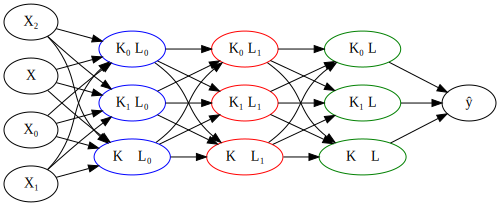

In [12]:
SUB = str.maketrans("0123456789mnk", "₀₁₂₃₄₅₆₇₈₉ₘₙₖ")

g = Digraph()
g = Digraph(graph_attr={'rankdir':'LR'})

g.node("K0 L0".translate(SUB), color="blue")
g.node("K1 L0".translate(SUB), color="blue")
g.node("Kn L0".translate(SUB), color="blue")

g.node("K0 L1".translate(SUB), color="red")
g.node("K1 L1".translate(SUB), color="red")
g.node("Kn L1".translate(SUB), color="red")

g.node("K0 Lm".translate(SUB), color="green")
g.node("K1 Lm".translate(SUB), color="green")
g.node("Kn Lm".translate(SUB), color="green")


g.edge("X0".translate(SUB), "K0 L0".translate(SUB))
g.edge("X0".translate(SUB), "K1 L0".translate(SUB))
g.edge("X0".translate(SUB), "Kn L0".translate(SUB))
g.edge("X1".translate(SUB), "K0 L0".translate(SUB))
g.edge("X1".translate(SUB), "K1 L0".translate(SUB))
g.edge("X1".translate(SUB), "Kn L0".translate(SUB))
g.edge("X2".translate(SUB), "K0 L0".translate(SUB))
g.edge("X2".translate(SUB), "K1 L0".translate(SUB))
g.edge("X2".translate(SUB), "Kn L0".translate(SUB))
g.edge("Xn".translate(SUB), "K0 L0".translate(SUB))
g.edge("Xn".translate(SUB), "K1 L0".translate(SUB))
g.edge("Xn".translate(SUB), "Kn L0".translate(SUB))

g.edge("K0 L0".translate(SUB), "K0 L1".translate(SUB))
g.edge("K0 L0".translate(SUB), "K1 L1".translate(SUB))
g.edge("K0 L0".translate(SUB), "Kn L1".translate(SUB))

g.edge("K1 L0".translate(SUB), "K0 L1".translate(SUB))
g.edge("K1 L0".translate(SUB), "K1 L1".translate(SUB))
g.edge("K1 L0".translate(SUB), "Kn L1".translate(SUB))

g.edge("Kn L0".translate(SUB), "K0 L1".translate(SUB))
g.edge("Kn L0".translate(SUB), "K1 L1".translate(SUB))
g.edge("Kn L0".translate(SUB), "Kn L1".translate(SUB))

g.edge("K0 L1".translate(SUB), "K0 Lm".translate(SUB))
g.edge("K0 L1".translate(SUB), "K1 Lm".translate(SUB))
g.edge("K0 L1".translate(SUB), "Kn Lm".translate(SUB))

g.edge("K1 L1".translate(SUB), "K0 Lm".translate(SUB))
g.edge("K1 L1".translate(SUB), "K1 Lm".translate(SUB))
g.edge("K1 L1".translate(SUB), "Kn Lm".translate(SUB))

g.edge("Kn L1".translate(SUB), "K0 Lm".translate(SUB))
g.edge("Kn L1".translate(SUB), "K1 Lm".translate(SUB))
g.edge("Kn L1".translate(SUB), "Kn Lm".translate(SUB))

g.edge("K0 Lm".translate(SUB), "ŷ".translate(SUB))
g.edge("K1 Lm".translate(SUB), "ŷ".translate(SUB))
g.edge("Kn Lm".translate(SUB), "ŷ".translate(SUB))

g

### MIP Formulation

__Parameters:__

$ x_{n,d}: \textit{binary vector inputs of size n} \times \textit{d, where n is the number of data points, d is the number of dimensions/features} $ 

$ y_{n}: \textit{ binary  vector labeled outputs of size n} \times \textit{1, where n is the number of data points} $

__Decision Variables:__

$ \alpha\prime_{d,k}: \textit{Weight for feature d in unit k in the first hidden layer,}\forall\;d\in D,\;k \in K $

$ \alpha_{k\prime,k,l}: \textit{Weight from the}\; k\prime^{th}\; \textit{unit in layer l-1 to unit k in layer l,}\forall\;k\prime,\;k \in K,\;l \in \{0,1,2,...,L-2\} $

$ \alpha_{(output)k\prime}: \textit{Weight from the} \;k\prime^{th}\; \textit{unit in layer L-1 to unit output layer L,}\forall\;\;k\prime \in K $

$ \beta_{k,l}: \textit{Bias for unit k in layer l,} \forall\;k \in K,\;l\in \{0,1,...,L-2\} $

$ \beta_{(output)}: \textit{Bias in the final layer } \textrm{Assuming the final layer has only one output, i.e, we have only one label. We would use} \; \beta_{m,L}\; \textrm{as the bias for the last layer in case we have m possible labels for each data point.} $

$ h_{n,k,l}: \textit{Binary output of unit k in layer l,} \forall\;n \in N, \;k \in K,\;l \in \{0,1,...L-2\} $

$ z_{n,k\prime,k,l}: \textit{Auxilliary variable that represents} \;\alpha_{k\prime,k,l}h_{n,k,(l-1)}, \forall\;n \in N, \;k\prime,\;k \in K,\;l \in \{1,2,...,L-2\} $

$ z_{n,k\prime,L-1}: \textit{Auxilliary variable that represents} \;\alpha_{(output)k\prime}h_{n,k,(L-2)}, \forall\;n \in N, \;k\prime,\;k \in K $

$ \hat{y}_{n}: \textit{Output of final layer,}\forall\;n \in N $

$ \ell\prime_{n}: \textit{Misclassification of data point n,}\forall\;n \in N $

$ \ell_{n}: \textit{Absolute Misclassification of data point n,}\forall\;n \in N $

__Objective:__

$\displaystyle \min_{\alpha,\beta,h,z,\hat{y},\ell\prime,\ell} \; \displaystyle  \sum_{n=1}^{N} \ell_{n} $

__Constraints:__

subject to $\quad \displaystyle \sum_{k\prime=0}^{K} (z_{n,k\prime,L-1}) + \beta_{(output)} \le -\epsilon + (M+\epsilon)\hat{y}_{n}, \; \forall \; n $

$ \quad\quad\quad\quad\;\; \displaystyle \sum_{k\prime=0}^{K} (z_{n,k\prime,L-1}) + \beta_{(output)} \ge \epsilon + (m-\epsilon)(1-\hat{y}_{n}), \; \forall \; n $

$ \quad\quad\quad\quad\;\; \ell\prime_{n} = y_{n} - \hat{y}, \; \forall \; n $

$ \quad\quad\quad\quad\;\; \ell_{n} = |\ell\prime_{n}|, \; \forall \; n$


$ \quad\quad\quad\quad\;\; \displaystyle \sum_{d=0}^{D} (\alpha\prime_{d,k}x_{n,d}) + \beta_{k,0} \le -\epsilon + (M+\epsilon)h_{n,k,0}, \; \forall \;n,k $

$ \quad\quad\quad\quad\;\; \displaystyle \sum_{d=0}^{D} (\alpha\prime_{d,k}x_{n,d}) + \beta_{k,0} \ge \epsilon + (m-\epsilon)(1-h_{n,k,0}), \; \forall \; n,k$

$ \quad\quad\quad\quad\ \displaystyle  \sum_{k\prime=0}^{K} (z_{n,k\prime,k,l}) + \beta_{k,l} \le -\epsilon + (M+\epsilon)h_{n,k,l}, \; \forall \;n,k,l\in\;\{1,2,...,L-2\} $

$ \quad\quad\quad\quad\ \displaystyle  \sum_{k\prime=0}^{K} (z_{n,k\prime,k,l}) + \beta_{k,l}  \ge \epsilon + (m-\epsilon)(1-h_{n,k,l}), \; \forall \; n,k,l\in\;\{1,2,...,L-2\}$

$ \quad\quad\quad\quad\;\; z_{n,k\prime,k,l} - \alpha_{k\prime,k,l} \le M(1-h_{n,k\prime,(l-1)}), \; \forall\;n,k,k\prime,l\in\;\{1,2,...,L-2\} $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,k,l} - \alpha_{k\prime,k,l} \ge m(1-h_{n,k\prime,(l-1)}), \; \forall\;n,k,k\prime,l\in\;\{1,2,...,L-2\} $

$ \quad\quad\quad\quad\;\;  mh_{n,k\prime,(l-1)} \le z_{n,k\prime,k,l} \le Mh_{n,k\prime,(l-1)}, \; \forall\;n,k,k\prime,l\in\;\{1,2,...,L-2\}$


$ \quad\quad\quad\quad\;\; z_{n,k\prime,L-1} - \alpha_{(output)k\prime} \le M(1-h_{n,k\prime,L-2}), \; \forall\;n,k\prime $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,L-1} - \alpha_{(output),k\prime} \ge m(1-h_{n,k\prime,L-2)}), \; \forall\;n,k\prime $

$ \quad\quad\quad\quad\;\;  mh_{n,k\prime,L-2} \le z_{n,k\prime,L-1} \le Mh_{n,k\prime,L-2}, \; \forall\;n,k\prime $

$ \quad\quad\quad\quad\;\; Lower\;Bound \le \alpha\prime_{d,k},\;\alpha_{k\prime,k,l},\;\alpha_{(output)k\prime} \le Upper\;Bound, \; \forall \; d,k,k\prime,l\in\;\{0,1,...,L-2\} $ 

$ \quad\quad\quad\quad\;\; Lower\;Bound \le ,\;z_{n,k\prime,k,l},\;z_{n,k\prime,L-1} \le Upper\;Bound, \; \forall \; n,k,k\prime,l\in\;\{1,2,...,L-2\} $ 

$ \quad\quad\quad\quad\;\; Lower\;Bound \le \beta_{k,l},\; \beta_{(output)} \le Upper\;Bound, \; \forall \; k,l\in\;\{0,1,...,L-2\}$

$ \quad\quad\quad\quad\;\; \hat{y}_{n},\;h_{n,k,l}  \in \{0,1\}, \; \forall \; n,k,l\in\;\{0,1,...,L-2\}$

$ \quad\quad\quad\quad\;\; -1 \le \ell\prime_{n} \le 1, \; \forall \; n \in N $

$ \quad\quad\quad\quad\;\; 0 \le \ell_{n} \le 1, \; \forall \; n \in N$


In [13]:
# The above MIP is parsed into the following function as python code using gurobi

def MultiLayerMIPOptimizer(data, output, units, layers, w_lb=-1, w_ub=1, b_lb=-1, b_ub=1): 
        
    # Create a new model
    m = gp.Model("MultiLayerNN")
    
    L = layers # number of layers
    K = units # number of units per layer
    N = output.shape[0] # number of units in the training set
    D = data[0].shape[0] # dimension of data
    epsilon = 0.01

    x = data # binary feature matrix n x d
    y = output # labeled data n x 1

    assert x.shape[0] == y.shape[0] # assert the same number of columns for the input and output
                                    # each data point has one corresponding output

    # Create variables
    
    w_first = {}
    w_hidden = {}
    w_output = {}
    beta = {}
    beta_final = None
    h = {}
    z = {}
    y_hat = {}
#     loss_prime = {}
    loss = {}

    for k in range(K):
        w_output[k] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="w_output"+str(k)) # weights for the output layer
        # actually k\prime but since it is also in K, it's alright to say k

        for d in range(D):
            w_first[(d,k)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="w_first"+str((d,k))) # weights for the first hidden layer
        for k_prime in range(K):
            for l in range(1,L-1):
                w_hidden[(k_prime,k,l)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="w_hidden"+str((k_prime,k,l))) # weights for all the other layers
    
        for l in range(0,L-1):
            beta[(k,l)] = m.addVar(lb=b_lb, ub=b_ub, vtype=GRB.CONTINUOUS, name="beta"+str((k,l))) # bias for each _hidden_ layer
    
    beta_final = m.addVar(lb=b_lb, ub=b_ub, vtype=GRB.CONTINUOUS, name="beta_final") # bias for the output layer
    
    for n in range(N):

        y_hat[n] = m.addVar(vtype=GRB.BINARY, name="y_hat"+str(n))
#         loss_prime[n] = m.addVar(lb=-1, ub=1, vtype=GRB.CONTINUOUS, name="loss_prime"+str(n))
        loss[n] = m.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name="loss"+str(n)) # loss
        
        for k in range(K):
            for l in range(0,L-1):
                h[(n,k,l)] = m.addVar(vtype=GRB.BINARY, name="h"+str((n,k,l))) # output of each _hidden_ layer
            for k_prime in range(K):
                for l in range(1,L-1):
                    z[(n,k_prime,k,l)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name= "z"+str((n,k_prime,k,l))) # Auxilliary variable. Double check lower bound
        
            z[(n,k,L-1)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name= "z"+str((n,k,L-1))) # Auxilliary variable. Double check lower bound
            # actually (n,k\prime,l) but since it is also in K, it's alright to say (n,k,l)
                        
    # Set objective
    m.setObjective(sum(loss[n] for n in range(N)), GRB.MINIMIZE)

    # Add constraints
        
    for n in range(N):
        
        m.addConstr(sum(z[(n,k_prime,L-1)] for k_prime in range(K)) + beta_final
                            <= 0.0 - epsilon + (K*w_ub+b_ub + epsilon)*y_hat[n], name="output_final1 "+str(n))

        m.addConstr(sum(z[(n,k_prime,L-1)] for k_prime in range(K)) + beta_final
                            >= 0.0 + epsilon + (K*w_lb+b_lb - epsilon)*(1-y_hat[n]), name="output_final2 "+str(n))

#         m.addConstr(loss_prime[n] == y[n] - y_hat[n], name="loss_prime"+str(n)+" definition") 
#         m.addConstr(loss[n] == abs_(loss_prime[n]), name="loss"+str(n)+" absolute")

        m.addConstr(loss[n] >= y[n] - y_hat[n], name = "C1 Loss Function"+str(n))
        m.addConstr(loss[n] >= -y[n] + y_hat[n], name = "C2 Loss Function"+str(n))
        
        for k in range(K):
            
            m.addConstr(sum(w_first[(d,k)]*x[n,d] for d in range(D)) + beta[(k,0)] 
                        <= 0.0 - epsilon + (D*w_ub+b_ub + epsilon)*h[(n,k,0)], name="output_first_layer1 "+str((n,k))) # M is sum of upper-bounds
            
            m.addConstr(sum(w_first[(d,k)]*x[n,d] for d in range(D)) + beta[(k,0)] 
                        >= 0.0 + epsilon + (D*w_lb+b_lb - epsilon)*(1-h[(n,k,0)]), name="output_first_layer2 "+str((n,k))) # m is sum of lower-bounds

            for l in range(1, L-1):
                m.addConstr(sum(z[(n,k_prime,k,l)] for k_prime in range(K)) + beta[(k,l)] 
                            <= 0.0 - epsilon + (K*w_ub+b_ub + epsilon)*h[(n,k,l)], name="output_general1 "+str((n,k_prime,k,l))) # M is sum of upper-bounds

                m.addConstr(sum(z[(n,k_prime,k,l)] for k_prime in range(K)) + beta[(k,l)] 
                            >= 0.0 + epsilon + (K*w_lb+b_lb - epsilon)*(1-h[(n,k,l)]), name="output_general2 "+str((n,k_prime,k,l))) # m is sum of lower-bounds
                
        for k_prime in range(K):
            for k in range(K):
                for l in range(1,L-1):
                    m.addConstr(z[(n,k_prime,k,l)] <= w_hidden[(k_prime,k,l)] + (w_ub-w_lb)*(1.0-h[(n,k_prime,l-1)]), name="auxilliary_def1 "+str((n,k_prime,k,l))) 
                    m.addConstr(z[(n,k_prime,k,l)] >= w_hidden[(k_prime,k,l)] + (w_lb-w_ub)*(1.0-h[(n,k_prime,l-1)]), name="auxilliary_def2 "+str((n,k_prime,k,l))) 
                    m.addConstr(z[(n,k_prime,k,l)] <= (w_ub)*h[(n,k_prime,l-1)], name="auxilliar_bound1 "+str((n,k,k_prime,l)))
                    m.addConstr(z[(n,k_prime,k,l)] >= (w_lb)*h[(n,k_prime,l-1)], name="auxilliar_bound2 "+str((n,k,k_prime,l)))

            m.addConstr(z[(n,k_prime,L-1)] <= w_output[k_prime] + (w_ub-w_lb)*(1.0-h[(n,k_prime,L-2)]), name="auxilliary_def_last1 "+str((n,k_prime,L))) 
            m.addConstr(z[(n,k_prime,L-1)] >= w_output[k_prime] + (w_lb-w_ub)*(1.0-h[(n,k_prime,L-2)]), name="auxilliary_def_last2 "+str((n,k_prime,L))) 
            m.addConstr(z[(n,k_prime,L-1)] <= (w_ub)*h[(n,k_prime,L-2)], name="auxilliar_bound_last1 "+str((n,k_prime,L)))
            m.addConstr(z[(n,k_prime,L-1)] >= (w_lb)*h[(n,k_prime,L-2)], name="auxilliar_bound_last1 "+str((n,k_prime,L)))
                               
    # Optimize model
    m.setParam('OutputFlag', 0)
    m.optimize()
    m.printQuality()

    output_dict = {}
    
    for v in m.getVars():
#         print('%s %s %g' % (v.varName, "=", np.round(v.x, 3)))
        output_dict[v.varName] = np.round(v.x, 3)

    print('Obj: %g' % m.objVal)
    
    return(m.objVal, output_dict)

In [14]:
X = np.array([[0,0],[0,1], [1,0], [1,1]])
Y = np.array([0,1,1,0])

In [16]:
loss, output = MultiLayerMIPOptimizer(X,Y,units=2,layers=4)
output

Obj: 0


{'w_output0': 1.0,
 'w_first(0, 0)': -1.0,
 'w_first(1, 0)': 1.0,
 'w_hidden(0, 0, 1)': -1.0,
 'w_hidden(0, 0, 2)': 0.02,
 'w_hidden(1, 0, 1)': 0.02,
 'w_hidden(1, 0, 2)': 0.02,
 'beta(0, 0)': -0.99,
 'beta(0, 1)': -0.01,
 'beta(0, 2)': -0.01,
 'w_output1': 1.0,
 'w_first(0, 1)': 1.0,
 'w_first(1, 1)': -1.0,
 'w_hidden(0, 1, 1)': 0.02,
 'w_hidden(0, 1, 2)': -1.0,
 'w_hidden(1, 1, 1)': -1.0,
 'w_hidden(1, 1, 2)': 0.02,
 'beta(1, 0)': -0.99,
 'beta(1, 1)': -0.01,
 'beta(1, 2)': -0.01,
 'beta_final': -0.99,
 'y_hat0': -0.0,
 'loss0': 0.0,
 'h(0, 0, 0)': -0.0,
 'h(0, 0, 1)': -0.0,
 'h(0, 0, 2)': -0.0,
 'z(0, 0, 0, 1)': 0.0,
 'z(0, 0, 0, 2)': 0.0,
 'z(0, 1, 0, 1)': 0.0,
 'z(0, 1, 0, 2)': 0.0,
 'z(0, 0, 3)': 0.0,
 'h(0, 1, 0)': -0.0,
 'h(0, 1, 1)': -0.0,
 'h(0, 1, 2)': -0.0,
 'z(0, 0, 1, 1)': 0.0,
 'z(0, 0, 1, 2)': 0.0,
 'z(0, 1, 1, 1)': 0.0,
 'z(0, 1, 1, 2)': 0.0,
 'z(0, 1, 3)': 0.0,
 'y_hat1': 1.0,
 'loss1': 0.0,
 'h(1, 0, 0)': 1.0,
 'h(1, 0, 1)': -0.0,
 'h(1, 0, 2)': 1.0,
 'z(1, 0, 0, 1)'

### Notes on Layer-wise training

Using a MIP to optimize weights for each layer one by one
1. Layer Freezing
    * Optimize one layer MIP
    * Remove outermost layer
    * Freeze outputs of previous layers
    * Add new layer
    * Re-add outermost layer
    * Re-train on new layer
    
     **Notes on Layer Freezing:** 
    * Do we modify our MIP somehow or can we recursively call the one-layer MIP function L times?

    * What if we formulate a new MIP that only optimizes the weights of one layer corresponding to the expected input of the next layer? We use our 2 layer MIP used first. Then the weights determined of that need to be the "expected input" used in our second MIP (the weights of the layer in the second MIP need be optimized such that the output of this layer are the weights used in the first layer of our first MIP.
    
    * Isn't this still only pretraining? It looks like we still have to use our Multilayer NN MIP at the end. This means that we still face the issue of the algorithm taking too long to solve the problem for a large L. 
   
<br><br>
2. Layer-wise method as laid out in end-of-end-to-end
    * Takes an NN as input (randomized weights, randomized biases, layers, units, layer that is to be trained etc.)
    * Here, all weights except for the one that needs to be trained is a parameter (not a variable)
        * Probably as a dict
    * Trainable layer weights and bias, and output of each layer are weights
    * Train to minimize loss
    
    **Notes:**
    * Mutual Information?
    * Simultaneous training vs iterative training. Update weights with each iteration?


### Layer-wise MIP formulation

__General parameters for all layers:__

$ x_{n,d}: \textit{binary vector inputs of size n} \times \textit{d, where n is the number of data points, d is the number of dimensions/features/} $ 

$ y_{n}: \textit{ binary  vector labeled outputs of size n} \times \textit{1, where n is the number of data points} $

$ w\prime_{d,k}:\textit{randomized weights for feature d in unit k of the first hidden layer} $

$ w_{k\prime,k,l}:\textit{randomized weights from the} \;k\prime^{th}\; \textit{unit in the} \;(l-1)^{st}\; \textit{layer to the}\;k^{th}\;\textit{unit in the} \;l^{th}\; \textit{layer, } \forall\;k\prime,\;k \in K,\;l \in \{2,3,4,...,L-1\} $

$ w_{(output)k\prime}:\textit{randomized weights from the}\;k\prime^{th}\;\textit{unit in the}\;(L-1)^{st}\;\textit{layer to unit output layer L,}\forall\;k\prime \in K $

$ b_{k,l}:\textit{randomized bias in unit k of layer l, }\forall\;l \in\;{1,2,...,L-1} $

$ b_{(final)}:\textit{randomized bias in the final layer} $

__For the first layer__

__Decision Variables:__

$ \alpha\prime_{d,k}:\textit{Weight for feature d in unit k in the first hidden layer,}\forall\;d\in D,\;k \in K $

$ \beta_{k,1}: \textit{Bias for unit k in the first layer}\forall\;k \in K $

$ h_{n,k,l}: \textit{Binary output of unit k in layer l,} \forall\;n \in N, \;k \in K,\;l \in \{1,2,...L-1\} $

$ z_{n,k\prime,l}: \textit{Auxilliary variable, } \forall\;n \in N, \;k\prime,\;k \in K,\;l \in \{2,3,...,L\} $ 

$ \hat{y}\prime_{n}: \textit{Raw output of final layer,}\forall\;n \in N $

$ \hat{y}_{n}: \textit{Binary activated output of final layer,}\forall\;n \in N $

$ \ell\prime_{n}: \textit{Misclassification of data point n,}\forall\;n \in N $

$ \ell_{n}: \textit{Absolute Misclassification of data point n,}\forall\;n \in N $

__Objective:__

$\displaystyle \min_{W,\beta,h,z,\hat{y}\prime,\hat{y},\ell\prime,\ell} \; \displaystyle  \sum_{n=1}^{N} \ell_{n} $

__Constraints:__

subject to $\quad \hat{y}\prime_{n} = (\displaystyle  \sum_{k\prime=1}^{K} z_{n,k\prime,L}) + b_{(final)}, \; \forall \; n,k $

$ \quad\quad\quad\quad\;\; \hat{y}_{n} = max(0,\hat{y}\prime_{n}), \; \forall \; n \in N $

$ \quad\quad\quad\quad\;\; \ell\prime_{n} = y_{n} - \hat{y}, \; \forall \; n \in N $

$ \quad\quad\quad\quad\;\; \ell_{n} = |\ell\prime_{n}|, \; \forall \; n \in N $


$ \quad\quad\quad\quad\;\; \alpha\prime_{d,k}^{T}x_{n} + \beta_{k,1} \le 0 - \epsilon + (M+\epsilon)h_{n,k,1}, \; \forall \;n,k,d $

$ \quad\quad\quad\quad\;\; \alpha\prime_{d,k}^{T}x_{n} + \beta_{k,1} \ge \epsilon + (m-\epsilon)(1-h_{n,k,1}), \; \forall \; n,k,d $

$ \quad\quad\quad\quad\ \displaystyle  \sum_{k\prime=1}^{K} (z_{n,k\prime,l}) + b_{k,l} \le 0 - \epsilon + (M+\epsilon)h_{n,k,l}, \; \forall \;n,k,l\in\;\{2,3,...,L-1\} $

$ \quad\quad\quad\quad\ \displaystyle  \sum_{k\prime=1}^{K} (z_{n,k\prime,l}) + b_{k,l}  \ge \epsilon + (m-\epsilon)(1-h_{n,k,l}), \; \forall \; n,k,l\in\;\{2,3,...,L-1\}$ 

$ $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,l} - w_{k\prime,k,l} \le M(1-h_{n,k,(l-1)}), \; \forall\;n,k,k\prime,l\in\;\{2,3,...,L-1\} $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,l} - w_{k\prime,k,l} \ge m(1-h_{n,k,(l-1)}), \; \forall\;n,k,k\prime,l\in\;\{2,3,...,L-1\} $

$ \quad\quad\quad\quad\;\;  0 \le z_{n,k\prime,l} \le h_{n,k,(l-1)}, \; \forall\;n,k,k\prime,l\in\;\{2,3,...,L-1\}$

$ $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,L} - w_{(output)k} \le M(1-h_{n,k,(L-1)}), \; \forall\;n,k,k\prime $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,L} - w_{(output)k} \ge m(1-h_{n,k,(L-1)}), \; \forall\;n,k,k\prime $

$ \quad\quad\quad\quad\;\;  0 \le z_{n,k\prime,L-1} \le h_{n,k,(L-2)}, \; \forall\;n,k,k\prime$

$ $

$ \quad\quad\quad\quad\;\; Lower\;Bound \le \alpha\prime_{d,k}\;\le Upper\;Bound, \; \forall \; d,k,k\prime $

$ \quad\quad\quad\quad\;\; Lower\;Bound \le \beta_{k,1} \le Upper\;Bound, \; \forall \; k $


$ \quad\quad\quad\quad\;\; \hat{y}_{n},\;h_{n,k,l}  \in \{0,1\}, \; \forall \; n,k,l\in\;\{1,2,...,L-1\}$


$ \quad\quad\quad\quad\;\; 0 \le \ell_{n} \le 1, \; \forall \; n \in N$



randomized needs to be a dictionary of dictionaries. An example is given below

In [16]:
K = 2
D = 2
L = 3

randomized = {"w_prime": {},
              "w": {},
              "w_output": {}, 
              "b": {},
              "b_output": None            
             }

for k in range(K):
        randomized["w_output"][k] = np.random.uniform(-1,1)
        # actually (k') but since it is also in K, it's alright to use in k in range(K)

        for d in range(D):
            randomized["w_prime"][(d,k)] = np.random.uniform(-1,1)
        for k_prime in range(K):
            for l in range(1,L-1):
                randomized["w"][(k_prime,k,l)] = np.random.uniform(-1,1)
    
        for l in range(0,L-1):
            randomized["b"][(k,l)] = np.random.uniform(-1,1)
    
randomized["b_output"] = np.random.uniform(-1,1)
randomized

{'w_prime': {(0, 0): -0.03932611760104643,
  (1, 0): -0.8679919923676873,
  (0, 1): -0.07183169524449107,
  (1, 1): 0.24498280206007017},
 'w': {(0, 0, 1): -0.17219569451237793,
  (1, 0, 1): -0.08326029618342945,
  (0, 1, 1): 0.6192098564103479,
  (1, 1, 1): 0.21168385373545484},
 'w_output': {0: 0.5304792459290306, 1: -0.7136208069865426},
 'b': {(0, 0): 0.8481820441141865,
  (0, 1): 0.8483666973687782,
  (1, 0): -0.7160509555664627,
  (1, 1): 0.9406208347816587},
 'b_output': 0.20349130540086824}

In [17]:
def Module1Solver(data, output, randomized, num_layers, units, w_lb=-1, w_ub=1, b_lb=-1, b_ub=1): 
    
    """
    This function trains the first layer in a neural network with given randomized weights and biases
    in a layer-wise fashion
    """
    
    # Extract information from NN (the randomized weights and biases)
    
    L = num_layers # number of layers
    K = units # number of units per layer
    N = output.shape[0] # number of units in the training set
    D = data[0].shape[0] # dimension of data
    epsilon = 0.01

    x = data # binary feature matrix n x d
    y = output # labeled data n x 1
    
    # Given that the parameters of the NN are formated as the dictionary above
    # we only use w, w_output, b, and b_output for Module 1
    
    w = randomized["w"]
    w_output = randomized["w_output"]
    b = randomized["b"]
    b_output = randomized["b_output"]

    assert x.shape[0] >= y.shape[0] # assert the same number of columns for the input and output
                                    # each data point as at least one corresponding output
    
    # Create a model to train the first layer
    m1 = gp.Model("First Layer MIP") 
    
    # Create variables
    
    alpha_prime = {}
    beta = {}
    h = {}
    z = {}
    y_hat_prime = {}
    y_hat = {}
    loss_prime = {}
    loss = {}

    for k in range(K):
        beta[k] = m1.addVar(lb=b_lb, ub=b_ub, vtype=GRB.CONTINUOUS, name="beta"+str(k)) # bias for the first layer
        for d in range(D):
            alpha_prime[(d,k)] = m1.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="alpha_prime"+str((d+1,k+1))) # weights for the first hidden layer
            
    for n in range(N):
        y_hat_prime[n] = m1.addVar(lb = w_lb+b_lb, ub = w_ub+b_ub, vtype=GRB.CONTINUOUS, name="y_hat_prime"+str(n))
        y_hat[n] = m1.addVar(vtype=GRB.BINARY, name="y_hat"+str(n))
        loss_prime[n] = m1.addVar(lb = -1, ub=1, vtype=GRB.CONTINUOUS, name="loss_prime"+str(n))
        loss[n] = m1.addVar(ub = 1, vtype=GRB.CONTINUOUS, name="loss"+str(n))
        
        for k in range(K):
            for l in range(0,L-1):
                h[(n,k,l)] = m1.addVar(vtype=GRB.BINARY, name="h"+str((n,k,l))) # output of each _hidden_ layer
            for l in range(1, L):
                z[(n,k,l)] = m1.addVar(lb=0, ub=w_ub, vtype=GRB.CONTINUOUS, name= "z"+str((n,k,l))) # Auxilliary variable. Double check lower bound
                # actually (n,k\prime,l) but since it is also in K, it's alright to say (n,k,l)

    
    # Set objective
    m1.setObjective(sum(loss[n] for n in range(N)), GRB.MINIMIZE)
    
    # Add constraints
    
    for n in range(N):
        
        m1.addConstr(y_hat_prime[n] == (sum(z[(n,k_prime,L-1)] for k_prime in range(K)) + b_output), name="y_hat_prime"+str(n)+" definition")
        m1.addConstr(y_hat[n] == max_(y_hat_prime[n],0), name="ReLU"+str(n))

        m1.addConstr(loss_prime[n] == y[n] - y_hat[n], name="loss_prime"+str(n)+" definition") 
        m1.addConstr(loss[n] == abs_(loss_prime[n]), name="loss"+str(n)+" absolute")

        
    for n in range(N):
        for k in range(K):
            
            m1.addConstr(sum(alpha_prime[(d,k)]*x[n,d] for d in range(D)) + beta[k] 
                        <= 0.0 - epsilon + (D*w_ub+b_ub + epsilon)*h[(n,k,0)], name="output_first_layer1 "+str((n,k))) # M is sum of upper-bounds
            
            m1.addConstr(sum(alpha_prime[(d,k)]*x[n,d] for d in range(D)) + beta[k] 
                        >= 0.0 + epsilon + (D*w_lb+b_lb - epsilon)*(1-h[(n,k,0)]), name="output_first_layer2 "+str((n,k))) # m is sum of lower-bounds

    for n in range(N):
        for k in range(K):
            for l in range(1, L-1):
                m1.addConstr(sum(z[(n,k_prime,l)] for k_prime in range(K)) + b[(k,l)] 
                            <= 0.0 - epsilon + (K*w_ub+b_ub + epsilon)*h[(n,k,l)], name="output_general1 "+str((n,k,l))) # M is sum of upper-bounds

                m1.addConstr(sum(z[(n,k_prime,l)] for k_prime in range(K)) + b[(k,l)] 
                            >= 0.0 + epsilon + (K*w_lb+b_lb - epsilon)*(1-h[(n,k,l)]), name="output_general2 "+str((n,k,l))) # m is sum of lower-bounds

    for n in range(N):
        for k_prime in range(K):
            for k in range(K):
                for l in range(1,L-1):
                    m1.addConstr(z[(n,k_prime,l)] <= w[(k_prime,k,l)] + (w_ub-w_lb)*(1.0-h[(n,k_prime,l-1)]), name="auxilliary_def1 "+str((n,k,k_prime,l))) 
                    m1.addConstr(z[(n,k_prime,l)] >= w[(k_prime,k,l)] + (w_lb-w_ub)*(1.0-h[(n,k_prime,l-1)]), name="auxilliary_def2 "+str((n,k,k_prime,l))) 
                    m1.addConstr(z[(n,k_prime,l)] <= (w_ub)*h[(n,k_prime,l-1)], name="auxilliar_bound1 "+str((n,k,k_prime,l)))
                
#                 m1.addConstr(z[(n,k_prime,L-1)] <= w_output[k_prime] + (w_ub-w_lb)*(1.0-h[(n,k_prime,L-2)]), name="auxilliary_def_last1 "+str((n,k,k_prime,L))) 
#                 m1.addConstr(z[(n,k_prime,L-1)] >= w_output[k_prime] + (w_lb-w_ub)*(1.0-h[(n,k_prime,L-2)]), name="auxilliary_def_last2 "+str((n,k,k_prime,L))) 
#                 m1.addConstr(z[(n,k_prime,L-1)] <= (w_ub)*h[(n,k_prime,L-2)], name="auxilliar_bound_last "+str((n,k,k_prime,L)))
                                
    # Optimize model
    m1.optimize()
    
    output_dict = {}
    
    for v in m1.getVars():
#         print('%s %s %g' % (v.varName, "=", np.round(v.x, 3)))
        output_dict[v.varName] = np.round(v.x, 3)

    print('Obj: %g' % m1.objVal)
    
    return(m1.objVal, output_dict)

----------------------------------------------------------------------------------------------------------------------

__For the middle hidden layers__ (loop over range(2,L-1))

__Decision Variables:__

$ \alpha_{k\prime,k,t}: \textit{Weight from the} \;k\prime^{th}\; \textit{unit in layer t-1  to unit k in the trainable layer t, }\forall\;k\prime,\;k \in K$

$ \beta_{k,t}: \textit{Bias for unit k in the trainable layer t, }\forall\;k \in K $

$ h_{n,k,l}: \textit{Binary output of unit k in layer l,} \forall\;n \in N, \;k \in K,\;l \in \{1,2,...L-1\} $

$ z_{n,k\prime,l}: \textit{Auxilliary variable, } \forall\;n \in N, \;k\prime,\;k \in K,\;l \in \{2,3,...,L\} $ 

$ \hat{y}\prime_{n}: \textit{Raw output of final layer,}\forall\;n \in N $

$ \hat{y}_{n}: \textit{Binary activated output of final layer,}\forall\;n \in N $

$ \ell\prime_{n}: \textit{Misclassification of data point n,}\forall\;n \in N $

$ \ell_{n}: \textit{Absolute Misclassification of data point n,}\forall\;n \in N $


__Objective:__

$\displaystyle \min_{W,\beta,h,z,\hat{y}\prime,\hat{y},\ell\prime,\ell} \; \displaystyle  \sum_{n=1}^{N} \ell_{n} $

__Constraints:__

subject to $\quad \hat{y}\prime_{n} = (\displaystyle  \sum_{k\prime=1}^{K} z_{n,k\prime,L}) + b_{(final)}, \; \forall \; n,k $

$ \quad\quad\quad\quad\;\; \hat{y}_{n} = max(0,\hat{y}\prime_{n}), \; \forall \; n \in N $

$ \quad\quad\quad\quad\;\; \ell\prime_{n} = y_{n} - \hat{y}, \; \forall \; n \in N $

$ \quad\quad\quad\quad\;\; \ell_{n} = |\ell\prime_{n}|, \; \forall \; n \in N $


$ \quad\quad\quad\quad\;\; w\prime_{d,k}^{T}x_{n} + b_{k,1} \le 0 - \epsilon + (M+\epsilon)h_{n,k,1}, \; \forall \;n,k,d $

$ \quad\quad\quad\quad\;\; w\prime_{d,k}^{T}x_{n} + b_{k,1} \ge \epsilon + (m-\epsilon)(1-h_{n,k,1}), \; \forall \; n,k,d $

$ \quad\quad\quad\quad\ \displaystyle  \sum_{k\prime=1}^{K} (z_{n,k\prime,t}) + \beta_{k,t} \le 0 - \epsilon + (M+\epsilon)h_{n,k,l}, \; \forall \;n,k,t\;is\;the\;trainable\;layer $

$ \quad\quad\quad\quad\ \displaystyle  \sum_{k\prime=1}^{K} (z_{n,k\prime,t}) + \beta_{k,t}  \ge \epsilon + (m-\epsilon)(1-h_{n,k,l}), \; \forall \; n,k,t\;is\;the\;trainable\;layer $ 

$ \quad\quad\quad\quad\ \displaystyle  \sum_{k\prime=1}^{K} (z_{n,k\prime,l}) + b_{k,l} \le 0 - \epsilon + (M+\epsilon)h_{n,k,l}, \; \forall \;n,k,l\in\;\{2,3,...,L-1\}-\{t\} $

$ \quad\quad\quad\quad\ \displaystyle  \sum_{k\prime=1}^{K} (z_{n,k\prime,l}) + b_{k,l}  \ge \epsilon + (m-\epsilon)(1-h_{n,k,l}), \; \forall \; n,k,l\in\;\{2,3,...,L-1\}-\{t\} $ 


$ $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,t} - \alpha_{k\prime,k,t} \le M(1-h_{n,k,(t-1)}), \; \forall\;n,k,k\prime,t\;is\;the\;trainable\;layer $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,t} - \alpha_{k\prime,k,t} \ge m(1-h_{n,k,(t-1)}), \; \forall\;n,k,k\prime,t\;is\;the\;trainable\;layer $

$ \quad\quad\quad\quad\;\;  0 \le z_{n,k\prime,t} \le h_{n,k,(t-1)}, \; \forall\;n,k,k\prime,t\;is\;the\;trainable\;layer $

$ $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,l} - w_{k\prime,k,l} \le M(1-h_{n,k,(l-1)}), \; \forall\;n,k,k\prime,l\in\;\{2,3,...,L-1\}-\{t\} $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,l} - w_{k\prime,k,l} \ge m(1-h_{n,k,(l-1)}), \; \forall\;n,k,k\prime,l\in\;\{2,3,...,L-1\}-\{t\} $

$ \quad\quad\quad\quad\;\;  0 \le z_{n,k\prime,l} \le h_{n,k,(l-1)}, \; \forall\;n,k,k\prime,l\in\;\{2,3,...,L-1\}-\{t\}$

$ $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,L} - w_{(output)k} \le M(1-h_{n,k,(L-1)}), \; \forall\;n,k,k\prime $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,L} - w_{(output)k} \ge m(1-h_{n,k,(L-1)}), \; \forall\;n,k,k\prime $

$ \quad\quad\quad\quad\;\;  0 \le z_{n,k\prime,L} \le h_{n,k,(L-1)}, \; \forall\;n,k,k\prime$

$ $

$ \quad\quad\quad\quad\;\; Lower\;Bound \le\;\alpha_{k\prime,k,t}\;\le Upper\;Bound, \; \forall \; d,k,k\prime,t\;is\;the\;trainable\;layer$

$ \quad\quad\quad\quad\;\; Lower\;Bound \le \beta_{k,t} \le Upper\;Bound, \; \forall \; k,t\;is\;the\;trainable\;layer$


$ \quad\quad\quad\quad\;\; \hat{y}_{n},\;h_{n,k,l}  \in \{0,1\}, \; \forall \; n,k,l\in\;\{1,2,...,L-1\}$


$ \quad\quad\quad\quad\;\; 0 \le \ell_{n} \le 1, \; \forall \; n \in N$



In [18]:
def Module2Solver(data, output, randomized, num_layers, units, layer_to_train, w_lb=-1, w_ub=1, b_lb=-1, b_ub=1): 
    
    """
    This function trains a middle hidden layer in a neural network with given randomized weights and biases
    in a layer-wise fashion
    """
    
    # Extract information from NN (the randomized weights and biases)
    
    L = num_layers # number of layers
    K = units # number of units per layer
    N = output.shape[0] # number of units in the training set
    D = data[0].shape[0] # dimension of data
    t = layer_to_train # Layer to train in a specific iteration
    epsilon = 0.01

    x = data # binary feature matrix n x d
    y = output # labeled data n x 1
    
    # Given that the parameters of the NN are formated as the dictionary above
    # we use all the information except the randomized values of the trainable layer
    
    w_prime = randomized["w_prime"]
    w = randomized["w"]
    w_output = randomized["w_output"]
    b = randomized["b"]
    b_output = randomized["b_output"]

    assert x.shape[0] >= y.shape[0] # assert the same number of columns for the input and output
                                    # each data point as at least one corresponding output
    
    assert 1 <= t <= L-1 # assert that this solver is only used for "middle" hidden layers
    
    # Create a model to train the first layer
    m2 = gp.Model("Middle Layer MIP") 
    
    # Create variables
    
    alpha = {}
    beta = {}
    h = {}
    z = {}
    y_hat_prime = {}
    y_hat = {}
    loss_prime = {}
    loss = {}

    for k in range(K):
        beta[(k,t)] = m2.addVar(lb=b_lb, ub=b_ub, vtype=GRB.CONTINUOUS, name="beta"+str((k,t))) # bias for the trainable hidden layer
        for k_prime in range(K):
            alpha[(k_prime,k,t)] = m2.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="alpha"+str((k_prime, k,t))) # weights for the trainable hidden layers
    
    for n in range(N):
        y_hat_prime[n] = m2.addVar(lb = w_lb+b_lb, ub = w_ub+b_ub, vtype=GRB.CONTINUOUS, name="y_hat_prime"+str(n))
        y_hat[n] = m2.addVar(vtype=GRB.BINARY, name="y_hat"+str(n))
        loss_prime[n] = m2.addVar(lb = -1, ub=1, vtype=GRB.CONTINUOUS, name="loss_prime"+str(n))
        loss[n] = m2.addVar(ub = 1, vtype=GRB.CONTINUOUS, name="loss"+str(n)) # loss
        
        for k in range(K):
            for l in range(1,L-1):
                h[(n,k,l)] = m2.addVar(vtype=GRB.BINARY, name="h"+str((n,k,l))) # output of each _hidden_ layer
            for l in range(1, L):
                z[(n,k,l)] = m2.addVar(lb=0, ub=w_ub, vtype=GRB.CONTINUOUS, name= "z"+str((n,k,l))) # Auxilliary variable. Double check lower bound
                # actually (n,k\prime,l) but since it is also in K, it's alright to say (n,k,l)
    
    # Set objective
    m2.setObjective(sum(loss[n] for n in range(N)), GRB.MINIMIZE)
    
    # Add constraints
    
    for n in range(N):
        
        m2.addConstr(y_hat_prime[n] == (sum(z[(n,k_prime,L-1)] for k_prime in range(K)) + b_output), name="y_hat_prime"+str(n)+" definition")
        m2.addConstr(y_hat[n] == max_(y_hat_prime[n],0), name="ReLU"+str(n))

        m2.addConstr(loss_prime[n] == y[n] - y_hat[n], name="loss_prime"+str(n)+" definition") 
        m2.addConstr(loss[n] == abs_(loss_prime[n]), name="loss"+str(n)+" absolute")

        
    for n in range(N):
        for k in range(K):
            
            output_0th = sum(w_prime[(d,k)]*x[n,d] for d in range(D)) + b[(k,0)] 
            if output_0th > 0:
                h[(n,k,0)] = 1
            else:
                h[(n,k,0)] = 0
            
#             m2.addConstr(sum(w_prime[(d,k)]*x[n,d] for d in range(D)) + b[(k,0)] 
#                          <= 0.0 - epsilon + (D*w_ub+b_ub + epsilon)*h[(n,k,0)], name="output_first_layer1 "+str((n,k))) # M is sum of upper-bounds
            
#             m2.addConstr(sum(w_prime[(d,k)]*x[n,d] for d in range(D)) + b[(k,0)] 
#                          >= 0.0 + epsilon + (D*w_lb+b_lb - epsilon)*(1-h[(n,k,0)]), name="output_first_layer2 "+str((n,k))) # m is sum of lower-bounds

            # The above two commented out constraints gave the following error: GurobiError: Constraint has no bool value (are you trying "lb <= expr <= ub"?)

    for n in range(N):
        for k in range(K):
            m2.addConstr(sum(z[(n,k_prime,t)] for k_prime in range(K)) + beta[(k,t)] 
                        <= 0.0 - epsilon + (K*w_ub+b_ub + epsilon)*h[(n,k,t)], name="output_trainable1 "+str((n,k,t))) # M is sum of upper-bounds

            m2.addConstr(sum(z[(n,k_prime,t)] for k_prime in range(K)) + beta[(k,t)] 
                        >= 0.0 + epsilon + (K*w_lb+b_lb - epsilon)*(1-h[(n,k,t)]), name="output_trainable2 "+str((n,k,t))) # m is sum of lower-bounds

    for n in range(N):
        for k in range(K):
            for l in range(1, L-1):
                if l == t:
                    continue # exclude the trainable layer from the randomized weight constraints
                    
                m2.addConstr(sum(z[(n,k_prime,l)] for k_prime in range(K)) + b[(k,l)] 
                            <= 0.0 - epsilon + (K*w_ub+b_ub + epsilon)*h[(n,k,l)], name="output_general1 "+str((n,k,l))) # M is sum of upper-bounds

                m2.addConstr(sum(z[(n,k_prime,l)] for k_prime in range(K)) + b[(k,l)] 
                            >= 0.0 + epsilon + (K*w_lb+b_lb - epsilon)*(1-h[(n,k,l)]), name="output_general2 "+str((n,k,l))) # m is sum of lower-bounds

    
    for n in range(N):
        for k_prime in range(K):
            for k in range(K):
                m2.addConstr(z[(n,k_prime,t)] <= alpha[(k_prime,k,t)] + (w_ub-w_lb)*(1.0-h[(n,k_prime,t-1)]), name="auxilliary_def_trainable1 "+str((n,k,k_prime,t))) 
                m2.addConstr(z[(n,k_prime,t)] >= alpha[(k_prime,k,t)] + (w_lb-w_ub)*(1.0-h[(n,k_prime,t-1)]), name="auxilliary_def_trainable2 "+str((n,k,k_prime,t))) 
                m2.addConstr(z[(n,k_prime,t)] <= (w_ub)*h[(n,k_prime,t-1)], name="auxilliary_bound_trainable1 "+str((n,k,k_prime,t)))
    
    for n in range(N):
        for k_prime in range(K):
            for k in range(K):
                for l in range(1,L-1):
                    if l == t:
                        continue
                        
                    m2.addConstr(z[(n,k_prime,l)] <= w[(k_prime,k,l)] + (w_ub-w_lb)*(1.0-h[(n,k_prime,l-1)]), name="auxilliary_def1 "+str((n,k,k_prime,l))) 
                    m2.addConstr(z[(n,k_prime,l)] >= w[(k_prime,k,l)] + (w_lb-w_ub)*(1.0-h[(n,k_prime,l-1)]), name="auxilliary_def2 "+str((n,k,k_prime,l))) 
                    m2.addConstr(z[(n,k_prime,l)] <= (w_ub)*h[(n,k_prime,l-1)], name="auxilliary_bound1 "+str((n,k,k_prime,l)))
                
                m2.addConstr(z[(n,k_prime,L-1)] <= w_output[k_prime] + (w_ub-w_lb)*(1.0-h[(n,k_prime,L-2)]), name="auxilliary_def_last1 "+str((n,k,k_prime,L))) 
                m2.addConstr(z[(n,k_prime,L-1)] >= w_output[k_prime] + (w_lb-w_ub)*(1.0-h[(n,k_prime,L-2)]), name="auxilliary_def_last2 "+str((n,k,k_prime,L))) 
                m2.addConstr(z[(n,k_prime,L-1)] <= (w_ub)*h[(n,k_prime,L-2)], name="auxilliary_bound_last "+str((n,k,k_prime,L)))
                                
    # Optimize model
    m2.optimize()
    
    output_dict = {}
    
    for v in m2.getVars():
        print('%s %s %g' % (v.varName, "=", np.round(v.x, 3)))
        output_dict[v.varName] = np.round(v.x, 3)

    print('Obj: %g' % m2.objVal)
    
    return(m2.objVal, output_dict)

----------------------------------------------------------------------------------------------------------------------

__For the last (output) layer__

__Decision Variables:__

$ \alpha_{(output)k\prime}: \textit{Weight from the} \;k\prime^{th}\; \textit{unit in layer L-1  to the output layer, } \forall\;k\prime \in K$

$ \beta_{(output)}: \textit{Bias in the final layer } \textrm{Assuming the final layer has only one output, i.e, we have only one label. We would use} \; \beta_{m,L}\; \textrm{as the bias for the last layer in case we have m possible labels for each data point.} $

$ h_{n,k,l}: \textit{Binary output of unit k in layer l,} \forall\;n \in N, \;k \in K,\;l \in \{1,2,...L-1\} $

$ z_{n,k\prime,l}: \textit{Auxilliary variable, } \forall\;n \in N, \;k\prime,\;k \in K,\;l \in \{2,3,...,L\} $ 

$ \hat{y}\prime_{n}: \textit{Raw output of final layer,}\forall\;n \in N $

$ \hat{y}_{n}: \textit{Binary activated output of final layer,}\forall\;n \in N $

$ \ell\prime_{n}: \textit{Misclassification of data point n,}\forall\;n \in N $

$ \ell_{n}: \textit{Absolute Misclassification of data point n,}\forall\;n \in N $


__Objective:__

$\displaystyle \min_{W,\beta,h,z,\hat{y}\prime,\hat{y},\ell\prime,\ell} \; \displaystyle  \sum_{n=1}^{N} \ell_{n} $

__Constraints:__

subject to $\quad \hat{y}\prime_{n} = (\displaystyle  \sum_{k\prime=1}^{K} z_{n,k\prime,L}) + \beta_{(output)}, \; \forall \; n,k $

$ \quad\quad\quad\quad\;\; \hat{y}_{n} = max(0,\hat{y}\prime_{n}), \; \forall \; n \in N $

$ \quad\quad\quad\quad\;\; \ell\prime_{n} = y_{n} - \hat{y}, \; \forall \; n \in N $

$ \quad\quad\quad\quad\;\; \ell_{n} = |\ell\prime_{n}|, \; \forall \; n \in N $


$ \quad\quad\quad\quad\;\; w\prime_{d,k}^{T}x_{n} + b_{k,1} \le 0 - \epsilon + (M+\epsilon)h_{n,k,1}, \; \forall \;n,k,d $

$ \quad\quad\quad\quad\;\; w\prime_{d,k}^{T}x_{n} + b_{k,1} \ge \epsilon + (m-\epsilon)(1-h_{n,k,1}), \; \forall \; n,k,d $

$ \quad\quad\quad\quad\ \displaystyle  \sum_{k\prime=1}^{K} (z_{n,k\prime,l}) + b_{k,l} \le 0 - \epsilon + (M+\epsilon)h_{n,k,l}, \; \forall \;n,k,l\in\;\{2,3,...,L-1\} $

$ \quad\quad\quad\quad\ \displaystyle  \sum_{k\prime=1}^{K} (z_{n,k\prime,l}) + b_{k,l}  \ge \epsilon + (m-\epsilon)(1-h_{n,k,l}), \; \forall \; n,k,l\in\;\{2,3,...,L-1\}$ 

$ \quad\quad\quad\quad\;\; z_{n,k\prime,l} - w_{k\prime,k,l} \le M(1-h_{n,k,(l-1)}), \; \forall\;n,k,k\prime,l\in\;\{2,3,...,L-1\} $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,l} - w_{k\prime,k,l} \ge m(1-h_{n,k,(l-1)}), \; \forall\;n,k,k\prime,l\in\;\{2,3,...,L-1\} $

$ \quad\quad\quad\quad\;\;  0 \le z_{n,k\prime,l} \le h_{n,k,(l-1)}, \; \forall\;n,k,k\prime,l\in\;\{2,3,...,L\}$

$ \quad\quad\quad\quad\;\; z_{n,k\prime,L} - \alpha_{(output)k} \le M(1-h_{n,k,(L-2)}), \; \forall\;n,k,k\prime $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,L} - \alpha_{(output)k} \ge m(1-h_{n,k,(L-2)}), \; \forall\;n,k,k\prime $

$ \quad\quad\quad\quad\;\;  0 \le z_{n,k\prime,L-1} \le h_{n,k,(L-1)}, \; \forall\;n,k,k\prime$


$ \quad\quad\quad\quad\;\; Lower\;Bound \le \alpha_{(output)k\prime}\;\le Upper\;Bound, \; \forall \; k\prime $

$ \quad\quad\quad\quad\;\; Lower\;Bound \le \beta_{(output)} \le Upper\;Bound $


$ \quad\quad\quad\quad\;\; \hat{y}_{n},\;h_{n,k,l}  \in \{0,1\}, \; \forall \; n,k,l\in\;\{1,2,...,L-1\}$


$ \quad\quad\quad\quad\;\; 0 \le \ell_{n} \le 1, \; \forall \; n \in N$



In [19]:
def Module3Solver(data, output, randomized, num_layers, units, w_lb=-1, w_ub=1, b_lb=-1, b_ub=1): 
    
    """
    This function trains the last/output layer in a neural network with given randomized weights and biases
    in a layer-wise fashion
    """
    
    # Extract information from NN (the randomized weights and biases)
    
    L = num_layers # number of layers
    K = units # number of units per layer
    N = output.shape[0] # number of units in the training set
    D = data[0].shape[0] # dimension of data
    epsilon = 0.01

    x = data # binary feature matrix n x d
    y = output # labeled data n x 1
    
    # Given that the parameters of the NN are formated as the dictionary above
    # we only use w', w, and b for Module 1
    
    w_prime = randomized["w_prime"]
    w = randomized["w"]
    b = randomized["b"]

    assert x.shape[0] >= y.shape[0] # assert the same number of columns for the input and output
                                    # each data point as at least one corresponding output
    
    # Create a model to train the first layer
    m3 = gp.Model("Final Layer MIP") 
    
    # Create variables
    
    alpha_output = {}
    beta_output = None
    h = {}
    z = {}
    y_hat_prime = {}
    y_hat = {}
    loss_prime = {}
    loss = {}

    for k in range(K):
        alpha_output[k] = m3.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="alpha_output"+str(k)) # weights for the output layer
        # actually k\prime but since it is also in K, it's alright to say k
        
    beta_output = m3.addVar(lb=b_lb, ub=b_ub, vtype=GRB.CONTINUOUS, name="beta_output") # bias for the output layer
    
    for n in range(N):
        y_hat_prime[n] = m3.addVar(lb = w_lb+b_lb, ub = w_ub+b_ub, vtype=GRB.CONTINUOUS, name="y_hat_prime"+str(n))
        y_hat[n] = m3.addVar(vtype=GRB.BINARY, name="y_hat"+str(n))
        loss_prime[n] = m3.addVar(lb = -1, ub=1, vtype=GRB.CONTINUOUS, name="loss_prime"+str(n))
        loss[n] = m3.addVar(ub = 1, vtype=GRB.CONTINUOUS, name="loss"+str(n)) # loss
        
        for k in range(K):
            for l in range(0,L-1):
                h[(n,k,l)] = m3.addVar(vtype=GRB.BINARY, name="h"+str((n,k,l))) # output of each _hidden_ layer
            for l in range(1, L):
                z[(n,k,l)] = m3.addVar(lb=0, ub=w_ub, vtype=GRB.CONTINUOUS, name= "z"+str((n,k,l))) # Auxilliary variable. Double check lower bound
                # actually (n,k\prime,l) but since it is also in K, it's alright to say (n,k,l)
    
    # Set objective
    m3.setObjective(sum(loss[n] for n in range(N)), GRB.MINIMIZE)
    
    # Add constraints
    
    for n in range(N):
        
        m3.addConstr(y_hat_prime[n] == (sum(z[(n,k_prime,L-1)] for k_prime in range(K)) + beta_output), name="y_hat_prime"+str(n)+" definition")
        m3.addConstr(y_hat[n] == max_(y_hat_prime[n],0), name="ReLU"+str(n))

        m3.addConstr(loss_prime[n] == y[n] - y_hat[n], name="loss_prime"+str(n)+" definition") 
        m3.addConstr(loss[n] == abs_(loss_prime[n]), name="loss"+str(n)+" absolute")

        
    for n in range(N):
        for k in range(K):
            
            output_0th = sum(w_prime[(d,k)]*x[n,d] for d in range(D)) + b[(k,0)] 
            if output_0th > 0:
                h[(n,k,0)] = 1
            else:
                h[(n,k,0)] = 0
            
#             m3.addConstr(sum(w_prime[(d,k)]*x[n,d] for d in range(D)) + b[(k,0)] 
#                         <= 0.0 - epsilon + (D*w_ub+b_ub + epsilon)*h[(n,k,0)], name="output_first_layer1 "+str((n,k))) # M is sum of upper-bounds
            
#             m3.addConstr(sum(w_prime[(d,k)]*x[n,d] for d in range(D)) + b[(k,0)] 
#                         >= 0.0 + epsilon + (D*w_lb+b_lb - epsilon)*(1-h[(n,k,0)]), name="output_first_layer2 "+str((n,k))) # m is sum of lower-bounds
            
            # The above two commented out constraints gave the following error: GurobiError: Constraint has no bool value (are you trying "lb <= expr <= ub"?)


    for n in range(N):
        for k in range(K):
            for l in range(1, L-1):
                m3.addConstr(sum(z[(n,k_prime,l)] for k_prime in range(K)) + b[(k,l)] 
                            <= 0.0 - epsilon + (K*w_ub+b_ub + epsilon)*h[(n,k,l)], name="output_general1 "+str((n,k,l))) # M is sum of upper-bounds

                m3.addConstr(sum(z[(n,k_prime,l)] for k_prime in range(K)) + b[(k,l)] 
                            >= 0.0 + epsilon + (K*w_lb+b_lb - epsilon)*(1-h[(n,k,l)]), name="output_general2 "+str((n,k,l))) # m is sum of lower-bounds

    for n in range(N):
        for k_prime in range(K):
            for k in range(K):
                for l in range(1,L-1):
                    m3.addConstr(z[(n,k_prime,l)] <= w[(k_prime,k,l)] + (w_ub-w_lb)*(1.0-h[(n,k_prime,l-1)]), name="auxilliary_def1 "+str((n,k,k_prime,l))) 
                    m3.addConstr(z[(n,k_prime,l)] >= w[(k_prime,k,l)] + (w_lb-w_ub)*(1.0-h[(n,k_prime,l-1)]), name="auxilliary_def2 "+str((n,k,k_prime,l))) 
                    m3.addConstr(z[(n,k_prime,l)] <= (w_ub)*h[(n,k_prime,l-1)], name="auxilliar_bound1 "+str((n,k,k_prime,l)))
                
                m3.addConstr(z[(n,k_prime,L-1)] <= alpha_output[k_prime] + (w_ub-w_lb)*(1.0-h[(n,k_prime,L-2)]), name="auxilliary_def_last1 "+str((n,k,k_prime,L))) 
                m3.addConstr(z[(n,k_prime,L-1)] >= alpha_output[k_prime] + (w_lb-w_ub)*(1.0-h[(n,k_prime,L-2)]), name="auxilliary_def_last2 "+str((n,k,k_prime,L))) 
                m3.addConstr(z[(n,k_prime,L-1)] <= (w_ub)*h[(n,k_prime,L-2)], name="auxilliar_bound_last "+str((n,k,k_prime,L)))
                                
    # Optimize model
    m3.optimize()
    
    output_dict = {}
    
    for v in m3.getVars():
        print('%s %s %g' % (v.varName, "=", np.round(v.x, 3)))
        output_dict[v.varName] = np.round(v.x, 3)

    print('Obj: %g' % m3.objVal)
    
    return(m3.objVal, output_dict)

In [185]:
X = np.array([[0,0],[0,1], [1,0], [1,1]])
Y = np.array([0,1,1,0])

In [186]:
Module1Solver(X, Y, randomized, num_layers = 3, units = 2, w_lb=-1, w_ub=1, b_lb=-1, b_ub=1)

# Module1Solver is infeasible

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 88 rows, 54 columns and 212 nonzeros
Model fingerprint: 0xf810833f
Model has 8 general constraints
Variable types: 34 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+00]
  RHS range        [1e-02, 3e+00]
Presolve removed 88 rows and 54 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Obj: 0


(0.0,
 {'beta0': -1.0,
  'alpha_prime(1, 1)': -1.0,
  'alpha_prime(2, 1)': -1.0,
  'beta1': -1.0,
  'alpha_prime(1, 2)': -1.0,
  'alpha_prime(2, 2)': -1.0,
  'y_hat_prime0': 0.0,
  'y_hat0': 0.0,
  'loss_prime0': 0.0,
  'loss0': -0.0,
  'h(0, 0, 0)': 0.0,
  'h(0, 0, 1)': 1.0,
  'z(0, 0, 1)': 0.0,
  'z(0, 0, 2)': 0.0,
  'h(0, 1, 0)': 0.0,
  'h(0, 1, 1)': 1.0,
  'z(0, 1, 1)': 0.0,
  'z(0, 1, 2)': 0.61,
  'y_hat_prime1': 1.0,
  'y_hat1': 1.0,
  'loss_prime1': 0.0,
  'loss1': 0.0,
  'h(1, 0, 0)': 0.0,
  'h(1, 0, 1)': 1.0,
  'z(1, 0, 1)': 0.0,
  'z(1, 0, 2)': 0.61,
  'h(1, 1, 0)': 0.0,
  'h(1, 1, 1)': 1.0,
  'z(1, 1, 1)': 0.0,
  'z(1, 1, 2)': 1.0,
  'y_hat_prime2': 1.0,
  'y_hat2': 1.0,
  'loss_prime2': 0.0,
  'loss2': 0.0,
  'h(2, 0, 0)': 0.0,
  'h(2, 0, 1)': 1.0,
  'z(2, 0, 1)': 0.0,
  'z(2, 0, 2)': 1.0,
  'h(2, 1, 0)': 0.0,
  'h(2, 1, 1)': 1.0,
  'z(2, 1, 1)': 0.0,
  'z(2, 1, 2)': 0.61,
  'y_hat_prime3': 0.0,
  'y_hat3': 0.0,
  'loss_prime3': 0.0,
  'loss3': -0.0,
  'h(3, 0, 0)': 0.0,
  

In [138]:
# Module2Solver(X, Y, randomized, num_layers=3, units=2, layer_to_train=1, w_lb=-1, w_ub=1, b_lb=-1, b_ub=1)

# Module2Solver is infeasible

In [139]:
# Module3Solver(X, Y, randomized, num_layers = 3, units = 2, w_lb=-1, w_ub=1, b_lb=-1, b_ub=1)

# Module2Solver is also infeasible

### ---------------------------------------------------------------------------------------------------------------------------------------

# Rough work and extra resources

In [ ]:
def calcMleForAlpha(steps, treatment, alpha):
    """
    This method evaluates an LP for the given value of alpha and returns the log
    likelihood value as well as the best beta value
    """
    m = Model('MLE Problem')
    training_time = len(steps)
    steps = list(steps)
    treatment = list(treatment)
    #Creating Decision variables
    theta = {}
    z = {}
    for ind in range(training_time):
        #only add variables to objective if we observed data at that time step
        step = steps[ind]
        if step <= 1e-10:
            if treatment[ind]:
                theta[ind] = m.addVar(lb=0.0,ub=1.0,obj=-1.0,name="theta"+str(ind))
            else:
                theta[ind] = m.addVar(lb=0.0,ub=1.0,obj=0.0,name="theta"+str(ind))
        elif step >= 0.999999:
            if treatment[ind]:
                theta[ind] = m.addVar(lb=0.0,ub=1.0,obj=1.0,name="theta"+str(ind))
            else:
                theta[ind] = m.addVar(lb=0.0,ub=1.0,obj=0.0,name="theta"+str(ind))
        else:
            if treatment[ind]:
                theta[ind] = m.addVar(lb=0.0,ub=1.0,obj=0.0,name="theta"+str(ind))
                z[ind] = m.addVar(lb=0.0,ub=2.0,obj=-1.0,name="z"+str(ind))
            else:
                theta[ind] = m.addVar(lb=0.0,ub=1.0,obj=0.0,name="theta"+str(ind))
                z[ind] = m.addVar(lb=0.0,ub=1.0,obj=0.0,name="z"+str(ind))

   
    beta = m.addVar(lb=0.0,ub=1.0,obj=0.0,name="beta")
    #update model to add variables
    m.update()
   
    #create constraints
    theta_dynamics = {}
    abs_val_const_l = {}
    abs_val_const_r = {}
   
    for ind in range(training_time-1):
        theta_dynamics = m.addConstr(alpha*theta[ind] + beta*(1-treatment[ind]) -theta[ind+1],"==",0.0,name="theta_dynamics"+str(ind))
   
    for ind in z.keys():
#        print(str(type(steps[ind]))
        abs_val_const_l = m.addConstr(z[ind],">=",float(steps[ind]) - theta[ind], name="abs_valconst_l"+str(ind))
        abs_val_const_r = m.addConstr(z[ind],">=",theta[ind] - float(steps[ind]) , name="abs_valconst_l"+str(ind))
       
    theta_init_cond = m.addConstr(theta[0],"==",beta/(1-alpha),name="theta_init_cond")
    beta_range = m.addConstr(beta ,"<=",1-alpha,name="beta_range")
   
    #update model to add constraints
    m.update()
    #set solver parameters
    m.modelSense = GRB.MAXIMIZE
    m.params.outputflag = 0
    m.update()    
    #solve model    
    m.optimize()
   
    like_val = m.objVal
   
   
    return (like_val,beta.X)